# Burgers equation in 1D: joint estimation (vanilla inverse problem)

**In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\theta$**. The dynamic, boundary and initial condition losses will be the same as in the [introductory notebook](https://mia_jinns.gitlab.io/jinns/Notebooks/Tutorials/implementing_your_own_PDE_problem/) but we will also **make use of available observations** and we will also **differentiate the dynamic loss with respect to the equation parameter $\theta$**.

We will work with the Burgers equation:

$$
\begin{equation}
\tag{PDE}
\begin{cases}
&\frac{\partial}{\partial t} u_\nu(t,x) + u_\nu(t,x)\frac{\partial}{\partial x} u_\nu(t,x) - \theta \frac{\partial^2}{\partial x^2} u_\nu(t,x) = 0,  \forall (t,x)\in I\times\Omega,&\text{ (Dynamic)} \\
&u_\nu(0, x) = -\sin(\pi x), \forall x\in\partial\Omega, &\text{ (initial condition)}\\
&u_\nu(t,-1)=u_\nu(t,1)=0, \forall t\in I, &\text{ (boundary condition)}
\end{cases}
\end{equation}
$$

We choose the time interval $I=[0,1]$ and the domain $\Omega=[-1,1]$. We denote by $\partial\Omega$ the boundary domain.

Therefore, we aim at solving:

$$
\hat{\nu},\hat{\theta}=\text{argmin}_{\nu,\theta} \mathcal{L}(\nu,\theta)
$$
with the loss:

$$
\begin{align*}
\mathcal{L}(\nu,\theta)&=\sum_{i}^{n_x}\sum_j^{n_t}\Big(u_\nu(t_j,x_i) + u_\nu(t_j,x_i)\frac{\partial}{\partial x}
          u_\nu(t_j,x_i) - \theta \frac{\partial^2}{\partial x^2} u_\nu(t_j,x_i)\Big)^2\\
&+w_{ic}\sum_i^{nx}\Big(u_\nu(0,x_i)-(-\sin(\pi x_i))\Big)^2\\
&+w_{bc}\sum_j^{n_t}\Big[\Big(u_\nu(t_j,-1)\Big)^2+\Big(u_\nu(t_j,1)\Big)^2\Big]
\end{align*}
$$

**Note that this approach could be much more refined by working on the optimization scheme**: alternative optimizers for $\nu$ and $\theta$, pre-training for $\nu$ only, etc. This tutorial only gives a first idea on how to tackle inverse problems with **jinns**.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt

In [4]:
key = jax.random.PRNGKey(42)

## Define the equation parameters

In [5]:
# True is : theta = 1 / (100 * jnp.pi)
key, subkey = jax.random.split(key)
theta_ori = jnp.array([1 / (100 * jnp.pi)])
print(f"{theta_ori=}")
theta = theta_ori + jax.random.normal(subkey, shape=(1,)) * 0.1
print(f"{theta=}")

theta_ori=Array([0.0031831], dtype=float32)
theta=Array([0.06375951], dtype=float32)


## Observations

We use artificial observations from the estimated solution from the other notebook on Burgers equation. You can [download it here](https://gitlab.com/mia_jinns/jinns/-/raw/main/Notebooks/Tutorials/burger_solution_grid.npy?.ref_type=heads&inline=false)

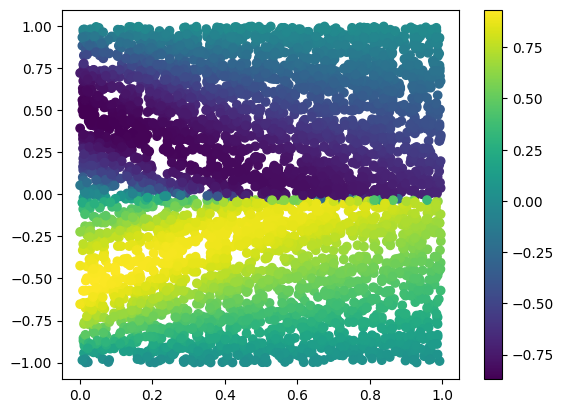

In [6]:
observations = jnp.load("burgers_solution_grid.npy")
key, subkey = jax.random.split(key)
size_subsample = 5000
time_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[0], 1),
    shape=(size_subsample,),
    replace=True,  # we do not have enough observations
)
key, subkey = jax.random.split(key)
size_subsample = 5000
omega_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[1], 1),
    shape=(size_subsample,),
    replace=True,  # we do not have enough observations
)
obs_batch = observations[time_subsample, omega_subsample]

plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()

__Optionally blur the observed values__

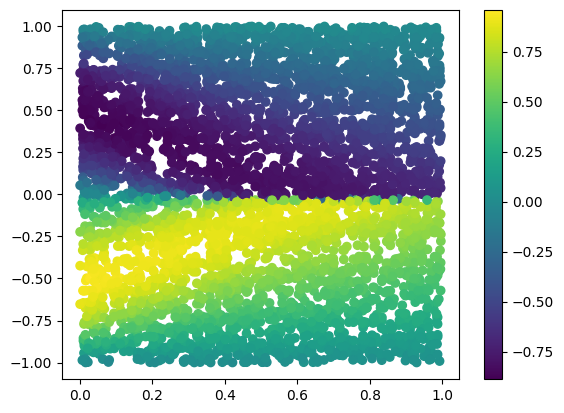

In [7]:
obs_batch_ori = obs_batch.copy()
key, subkey = jax.random.split(key)
obs_batch = obs_batch.at[:, 2].set(
    obs_batch[:, 2] + jax.random.normal(subkey, obs_batch[:, 2].shape) * 0.01
)


plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()

## Estimate the solution to the Burgers equation as well as the viscosity coefficient

*Define the domain and the associated data generator*

In [8]:
n = 5000
ni = 5000
nb = 2
domain_batch_size = 32
initial_batch_size = 32
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=domain_batch_size,
    initial_batch_size=initial_batch_size,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

*Define the data generator for the observations*

In [9]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    subkey, 32, observed_pinn_in=obs_batch[:, :2], observed_values=obs_batch[:, 2:3]
)

*Define the PINN*

Create the neural network architecture for the PINN with `equinox`.

In [10]:
eqx_list = (
    (eqx.nn.Linear, 2, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 1),
)
key, subkey = jax.random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="nonstatio_PDE"
)

*Define the jinns parameter object*

In [11]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "theta": theta,
    },
)

*Define the loss weights*

In [12]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1.0,
    initial_condition=1.0,
    boundary_loss=1.0,
    observations=1.0,
)

*Define the initial condition*

Text(0.5, 1.0, 'Init condition $u_0$')

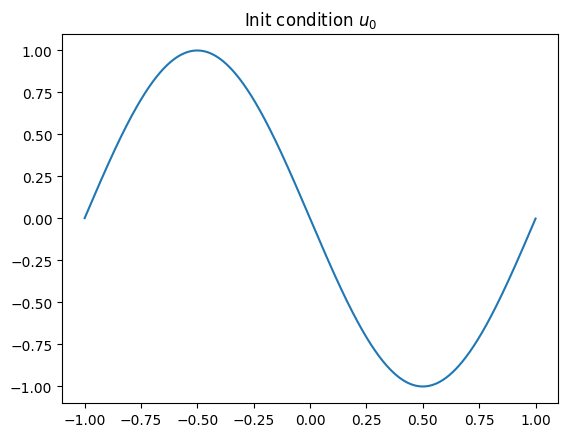

In [13]:
def u0(x):
    return -jnp.sin(jnp.pi * x)


plt.plot(
    train_data.domain[:, 1].sort(axis=0),
    jax.vmap(u0, (0), 0)(train_data.domain[:, 1].sort(axis=0)),
)
plt.title(r"Init condition $u_0$")

*Define the dynamic loss term*

In [14]:
from jinns.loss import PDENonStatio

from jaxtyping import Float, Array

import jinns.parameters


class BurgersEquation(PDENonStatio):
    r"""
    Return the Burgers dynamic loss term (in 1 space dimension):

    $$
        \frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
        u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0
    $$
    """

    def equation(
        self,
        t_x: Float[Array, "1+dim"],
        u: eqx.Module,
        params: jinns.parameters.Params,
    ) -> Float[Array, "1"]:
        r"""
        Evaluate the dynamic loss at :math:`(t,x)`.

        Parameters
        ---------
        t_x
            A collocation point in $I\times\Omega$
        u
            The PINN
        params
            The dictionary of parameters of the model.
        """
        u_ = lambda t_x: jnp.squeeze(u(t_x, params)[u.slice_solution])
        du_dtx = jax.grad(u_)
        d2u_dx_dtx = jax.grad(lambda t_x: du_dtx(t_x)[1])
        du_dtx_values = du_dtx(t_x)

        return du_dtx_values[0:1] + self.Tmax * (
            u_(t_x) * du_dtx_values[1:2] - params.eq_params.theta * d2u_dx_dtx(t_x)[1:2]
        )


be_loss = BurgersEquation(Tmax=1)

*Define how to differentiate each term of the loss* Note that the main `params` of the problem must be passed since we use the `from_str()` constructor

In [15]:
derivative_keys_nu_and_theta = jinns.parameters.DerivativeKeysPDENonStatio.from_str(
    dyn_loss=jinns.parameters.Params(
        nn_params=True,
        eq_params={
            "theta": True,
        },
    ),
    boundary_loss="nn_params",
    initial_condition="nn_params",
    observations="nn_params",
    params=init_params,
)

*Define the PDE PINN losses*

In [16]:
loss_nu_and_theta = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    derivative_keys=derivative_keys_nu_and_theta,
    omega_boundary_fun=lambda t_dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0,
)

*Define the optimizer and set-up the optimization. In this example we demonstrate how to use different optimizers for $\nu$ and $\theta$. This is easily done with `optax.multi_transform` which takes as argument a `jinns.params.Params` PyTree where each of the leaf is a label corresponding to an optimizer. More details are in optax doc: https://optax.readthedocs.io/en/stable/api/combining_optimizers.html#optax.multi_transform*

In [17]:
params = init_params

param_labels = jinns.parameters.Params(
    nn_params="adamw",  # in this simple example we will use adamw for the nu
    eq_params={"theta": "rprop"},  # in this simple example we will use rprop for theta
)

tx_nu_and_theta = optax.multi_transform(
    {
        "adamw": optax.adamw(learning_rate=1e-5),
        "rprop": optax.rprop(1e-4),
    },  # all the keys in this dict must be found as leaves in the PyTree param_labels
    param_labels,
)

key, subkey = jax.random.split(key, 2)
n_iter_nu_and_theta = 200000

*Define which parameters to track: $\theta$*

In [18]:
tracked_params = jinns.parameters.Params(eq_params={"theta": True})

*Run the optimization on $\nu$ and $\theta$*

In [19]:
params, total_loss_list, loss_by_term_dict, _, _, _, stored_params, _, _, _ = (
    jinns.solve(
        init_params=params,
        data=train_data,
        optimizer=tx_nu_and_theta,
        loss=loss_nu_and_theta,
        n_iter=n_iter_nu_and_theta,
        tracked_params=tracked_params,
        obs_data=obs_data,
        print_loss_every=10000,
    )
)

Initialization time: 6.6258790493011475

Compilation took
 9.972074508666992 

[train] Iteration 0: loss value = 0.9515348672866821
[train] Iteration 10000: loss value = 0.12715816497802734
[train] Iteration 20000: loss value = 0.1091686487197876
[train] Iteration 30000: loss value = 0.055239006876945496
[train] Iteration 40000: loss value = 0.05514328181743622
[train] Iteration 50000: loss value = 0.05369309335947037
[train] Iteration 60000: loss value = 0.0786457359790802
[train] Iteration 70000: loss value = 0.04689823091030121
[train] Iteration 80000: loss value = 0.020659226924180984
[train] Iteration 90000: loss value = 0.027567671611905098
[train] Iteration 100000: loss value = 0.02655784599483013
[train] Iteration 110000: loss value = 0.05061207339167595
[train] Iteration 120000: loss value = 0.0408211350440979
[train] Iteration 130000: loss value = 0.02635299786925316
[train] Iteration 140000: loss value = 0.022994764149188995
[train] Iteration 150000: loss value = 0.034875977

## Results

In [20]:
print("True theta", theta_ori)
print("Initial guess for theta", theta)
print("Estimated theta", stored_params.eq_params.theta[-1])

True theta [0.0031831]
Initial guess for theta [0.06375951]
Estimated theta [0.02911445]


*Plot the tracked parameters*

In [21]:
colors = ["blue"]
plt.plot(stored_params.eq_params["theta"])
plt.axhline(y=theta_ori, color="r", linestyle="-")
plt.title("theta")
plt.ylim([-0.2, 0.2])
plt.show()

TypeError: 'EqParams' object is not subscriptable

*Plot the loss values*

In [ ]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

*Plot the PDE solutions learned by the PINN*

In [ ]:
u_est = lambda t_x: u(t_x, params)
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)
jinns.plot.plot1d_image(
    u_est,
    xdata=val_xdata,
    times=val_times,
    cmap="viridis",
    colorbar=True,
    figsize=(10, 10),
    title="u(t,x)",
)

In [ ]:
time_slices = [0, 0.2, 0.4, 1]
jinns.plot.plot1d_slice(u_est, xdata=val_xdata, time_slices=time_slices)